In [1]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPForImageClassification, CLIPProcessor, CLIPModel
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose, Resize, PILToTensor, ToTensor
import matplotlib.pyplot as plt
import scipy 
import torchvision
from torch.utils.data import DataLoader, Dataset

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImageTextDataset(Dataset):
    """
    a wrapper class for dataset
    outputs image, caption and label
    """
    def __init__(self, dataset, transform=None):
        self.dataset=dataset
        self.transform=transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        text = f'a photo of a {self.dataset.categories[label]}'
        return img, text, label
        

In [3]:
# some data are in grayscale, so we need to convert them to rgb
transform_rgb = torchvision.transforms.Lambda(lambda img: img.convert("RGB"))

transform = Compose([
    transform_rgb,
    PILToTensor(),
    Resize((224, 224)),
])

# There is something wrong with torchvision.datasets.Caltech101
# So i download the dataset and unzip it
dataset = datasets.Caltech101(
    root="data",
    download=False,
    transform=transform,
)
# wrap the dataset with the wrapper class so that it outputs image, caption and label
my_dataset = ImageTextDataset(dataset) 

train_data, val_data, test_data = torch.utils.data.random_split(my_dataset, [0.8, 0.1, 0.1])

('a photo of a emu', 'a photo of a rooster', 'a photo of a kangaroo', 'a photo of a dolphin', 'a photo of a schooner', 'a photo of a scissors', 'a photo of a airplanes', 'a photo of a Faces_easy', 'a photo of a airplanes', 'a photo of a llama', 'a photo of a butterfly', 'a photo of a Faces', 'a photo of a Faces', 'a photo of a lobster', 'a photo of a crayfish', 'a photo of a car_side', 'a photo of a airplanes', 'a photo of a Faces', 'a photo of a flamingo', 'a photo of a gramophone', 'a photo of a bass', 'a photo of a ferry', 'a photo of a Motorbikes', 'a photo of a chandelier', 'a photo of a cougar_face', 'a photo of a helicopter', 'a photo of a airplanes', 'a photo of a strawberry', 'a photo of a bonsai', 'a photo of a Faces_easy', 'a photo of a Motorbikes', 'a photo of a airplanes')
32
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 3, 224, 224])
emu


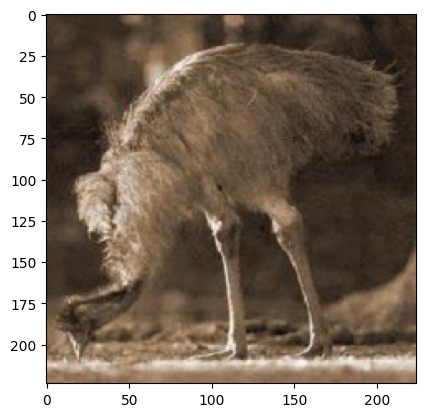

In [4]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

x_train, x_text, y_train = next(iter(train_loader))
print(x_text)
print(len(x_train))

print(f"Feature batch shape: {x_train.size()}")
print(f"Labels batch shape: {x_train.size()}")
img = x_train[0]
plt.imshow(img.permute(1, 2, 0)) # Convert from CHW to HWC
print(dataset.categories[y_train[0]])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')

In [6]:
# See zero-shot classification
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

train_label = [dataset.categories[i] for i in y_train]
text = [f'a photo of {i}' for i in dataset.categories]

inputs = processor(text=text, images=x_train, return_tensors="pt", padding=True)

inputs['input_ids'] = inputs['input_ids'].to(device)
inputs['attention_mask'] = inputs['attention_mask'].to(device)
inputs['pixel_values'] = inputs['pixel_values'].to(device)

y_train = y_train.to(device)
with torch.inference_mode():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  
pred = torch.argmax(probs, dim=1)
print(pred)
pred_label = [dataset.categories[i] for i in pred]
print(train_label)
print(pred_label)
print((pred == y_train).sum()/len(pred))

tensor([37, 77, 54, 33, 79, 80,  5,  7,  5, 58, 16,  1,  7, 59, 27, 53,  5, 40,
        41, 45,  9, 40,  3, 23, 97, 50,  5, 89, 12,  7,  3,  5],
       device='mps:0')
['emu', 'rooster', 'kangaroo', 'dolphin', 'schooner', 'scissors', 'airplanes', 'Faces_easy', 'airplanes', 'llama', 'butterfly', 'Faces', 'Faces', 'lobster', 'crayfish', 'car_side', 'airplanes', 'Faces', 'flamingo', 'gramophone', 'bass', 'ferry', 'Motorbikes', 'chandelier', 'cougar_face', 'helicopter', 'airplanes', 'strawberry', 'bonsai', 'Faces_easy', 'Motorbikes', 'airplanes']
['emu', 'rooster', 'kangaroo', 'dolphin', 'schooner', 'scissors', 'airplanes', 'ant', 'airplanes', 'llama', 'butterfly', 'Faces_easy', 'ant', 'lobster', 'crayfish', 'joshua_tree', 'airplanes', 'ferry', 'flamingo', 'gramophone', 'bass', 'ferry', 'Motorbikes', 'chandelier', 'wild_cat', 'helicopter', 'airplanes', 'strawberry', 'bonsai', 'ant', 'Motorbikes', 'airplanes']
tensor(0.7812, device='mps:0')


In [7]:
tmp_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tmp_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text = [f'a photo of {i}' for i in dataset.categories]

num_correct = 0
for x, _, y in test_loader:
    inputs = tmp_processor(images=x, text=text,return_tensors="pt", padding=True)
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    y = y.to(device)
    with torch.inference_mode():
        logits = tmp_model(**inputs).logits_per_image
        pred = torch.argmax(logits, dim=1)
        num_correct += (pred == y).sum()
print(num_correct/len(test_data))
    

tensor(0.7982, device='mps:0')


In [8]:
from model import CLIPWrapper, CLIPImageClassification
from lightning.pytorch.loggers import WandbLogger
import lightning as L

logger = WandbLogger(project="clip-image-classification")
model = CLIPImageClassification(num_classes=101).to(device)
lightning_model = CLIPWrapper(model)
trainer = L.Trainer(max_epochs=3, logger=logger, accelerator="gpu")
trainer.fit(lightning_model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLEL


  | Name  | Type                    | Params
--------------------------------------------------
0 | model | CLIPImageClassification | 150 M 
--------------------------------------------------
577 K     Trainable params
149 M     Non-trainable params
150 M     Total params
600.791   Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/217 [00:00<?, ?it/s] 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2: 100%|██████████| 217/217 [01:46<00:00,  2.03it/s, v_num=h6cd]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 217/217 [01:47<00:00,  2.02it/s, v_num=h6cd]


In [11]:
trained_model = lightning_model.model.to(device)
trained_model.eval()

text = [f'a photo of {i}' for i in dataset.categories]

num_correct = 0
for x, _, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    with torch.inference_mode():
        # if use similarity score, then uncomment the following line
        #logits = trained_model(x, text)[0]

        # if use classification score, then uncomment the following line
        logits = trained_model(x, text)
        pred = torch.argmax(logits, dim=1)
        num_correct += (pred == y).sum()
print(num_correct/len(test_data))
    

tensor(0.9158, device='mps:0')
